Importing Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Loading data :
[Dataset Link](https://www.kaggle.com/datasets/zhangluyuan/ab-testing/data)

In [29]:
df=pd.read_csv('/content/ab_data.csv')

In [30]:
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Checking missing values and duplicated in data

In [31]:
print(df.isnull().sum())
print(df.duplicated().sum())

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
0


No. of subjects per group

In [32]:
group_counts = df['group'].value_counts()
print(group_counts)

group
treatment    147276
control      147202
Name: count, dtype: int64


Checking misplaced data

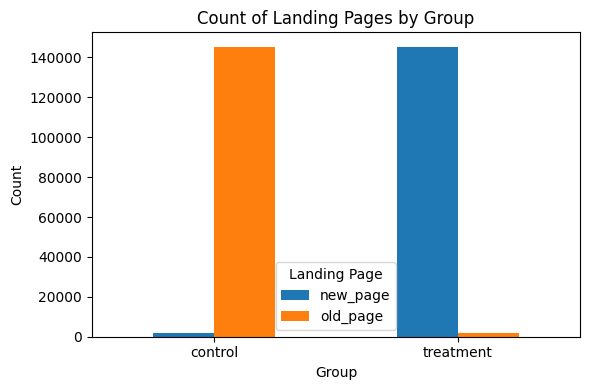

In [33]:
# Group by 'group' and count occurrences of each 'landing_page' within each group
groups_by_landing_page_counts = df.groupby('group')['landing_page'].value_counts().unstack()

# Plotting the bar graph
groups_by_landing_page_counts.plot(kind='bar', figsize=(6, 4))
plt.title('Count of Landing Pages by Group')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.legend(title='Landing Page')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [9]:
print(df.groupby(['group', 'landing_page']).size())

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64


Removing misplaced data

In [10]:


# Delete rows where group='control' and 'landing page='new_page'
df = df[~((df['group'] == 'control') & (df['landing_page'] == 'new_page'))]

print(df.groupby(['group', 'landing_page']).size())


group      landing_page
control    old_page        145274
treatment  new_page        145311
           old_page          1965
dtype: int64


In [11]:
df = df[~((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))]

print(df.groupby(['group', 'landing_page']).size())

group      landing_page
control    old_page        145274
treatment  new_page        145311
dtype: int64


Conversion rates

In [12]:
conversion_rates = df.groupby('group')['converted'].mean()
print(conversion_rates)

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64


Plotting conversion per landing page to check balance in data

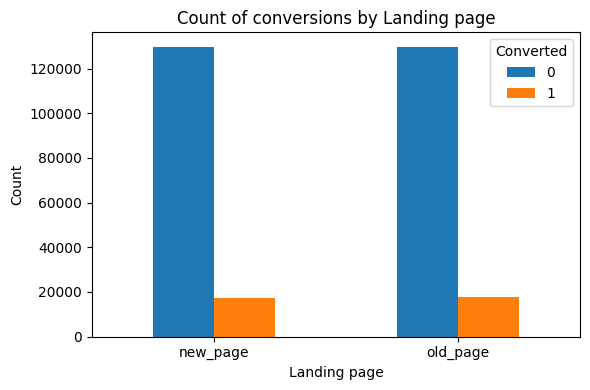

In [35]:
# Group by 'group' and count occurrences of each 'landing_page' within each group
landing_page_by_converted_counts = df.groupby('landing_page')['converted'].value_counts().unstack()

# Plotting the bar graph
landing_page_by_converted_counts .plot(kind='bar', figsize=(6, 4))
plt.title('Count of conversions by Landing page')
plt.xlabel('Landing page')
plt.ylabel('Count')
plt.xticks(rotation=0) # Keep x-axis labels horizontal
plt.legend(title='Converted')
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [23]:
print(df.groupby([ 'landing_page', 'converted']).size())

landing_page  converted
new_page      0            128047
              1             17264
old_page      0            127785
              1             17489
dtype: int64


As dataset is large we are going for K-S Test and Anderson-Darling Test to check normality

In [21]:
from scipy import stats

def check_normality(data, group_name):
    # Kolmogorov-Smirnov Test
    ks_test = stats.kstest(data, 'norm')
    ks_p_value = ks_test.pvalue

    # Anderson-Darling Test
    anderson_test = stats.anderson(data)
    ad_statistic = anderson_test.statistic
    critical_value = anderson_test.critical_values[2]  # 5% significance level

    print(f"\n📊 Normality Check for {group_name}:")

    # Kolmogorov-Smirnov Test Results
    print(f"KS Test p-value = {ks_p_value:.5f}")
    if ks_p_value < 0.05:
        print(f"❌ KS Test: Data for {group_name} is NOT normally distributed.")
    else:
        print(f"✅ KS Test: Data for {group_name} is approximately normal.")

    # Anderson-Darling Test Results
    print(f"Anderson-Darling Statistic = {ad_statistic:.5f}, Critical Value = {critical_value:.5f}")
    if ad_statistic > critical_value:
        print(f"❌ Anderson-Darling Test: Data for {group_name} is NOT normally distributed.")
    else:
        print(f"✅ Anderson-Darling Test: Data for {group_name} is approximately normal.")

# Extract conversion data for each group
control_conversions = df[df['group'] == 'control']['converted']
treatment_conversions = df[df['group'] == 'treatment']['converted']

# Run normality check for both groups
check_normality(control_conversions, "Control Group")
check_normality(treatment_conversions, "Treatment Group")



📊 Normality Check for Control Group:
KS Test p-value = 0.00000
❌ KS Test: Data for Control Group is NOT normally distributed.
Anderson-Darling Statistic = 45905.01391, Critical Value = 0.78700
❌ Anderson-Darling Test: Data for Control Group is NOT normally distributed.

📊 Normality Check for Treatment Group:
KS Test p-value = 0.00000
❌ KS Test: Data for Treatment Group is NOT normally distributed.
Anderson-Darling Statistic = 46067.87601, Critical Value = 0.78700
❌ Anderson-Darling Test: Data for Treatment Group is NOT normally distributed.


Mann- Whitney U Test as the data is not Normally distributed


Null Hypothesis (H₀): There is no significant difference in conversion rates between the Control and Treatment groups.

Alternative Hypothesis (H₁): There is a significant difference in conversion rates between the two groups.

In [24]:
from scipy.stats import mannwhitneyu

# Extract conversion data for each group
control_conversions = df[df['group'] == 'control']['converted']
treatment_conversions = df[df['group'] == 'treatment']['converted']

# Perform Mann-Whitney U Test
mw_stat, p_value = mannwhitneyu(control_conversions, treatment_conversions, alternative='two-sided')

# Print results
print(f"\n📊 Mann-Whitney U Test Results:")
print(f"U-statistic: {mw_stat}")
print(f"p-value: {p_value:.5f}")

# Interpretation
if p_value < 0.05:
    print("❌ Reject the null hypothesis: There is a significant difference between control and treatment groups.")
else:
    print("✅ Fail to reject the null hypothesis: No significant difference between control and treatment groups.")



📊 Mann-Whitney U Test Results:
U-statistic: 10571621978.5
p-value: 0.18965
✅ Fail to reject the null hypothesis: No significant difference between control and treatment groups.


In [27]:
lift = (conversion_rates['treatment'] - conversion_rates['control']) / conversion_rates['control']
print(f"Relative Lift: {lift:.2%}")


Relative Lift: -1.31%


We got to know that there is no significant difference in performance between control and test groups, infact the new page has slightly lower conversions than the old page.

Sometimes our result may not trusted as there may be a bias/ inconsistence in choosing users in the groups or there may other factors effecting the conversion rates other than landing_page

As we have timestamp column in our dataset lets check if there is a pattern in time that may be affecting conversion.

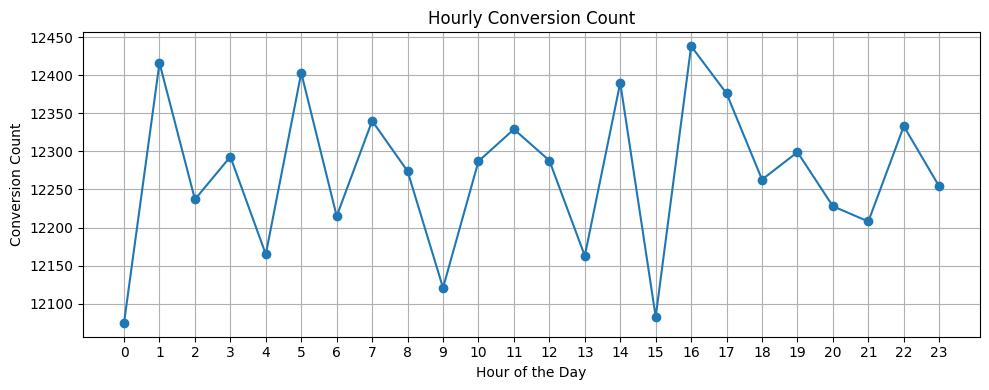

<ipython-input-52-eec924ef3329>:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Landing_Page')


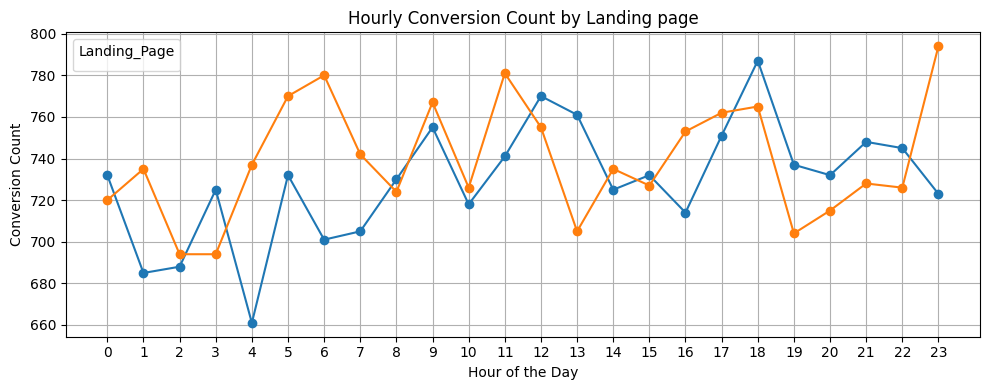

In [52]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract hourly timestamp
df['hour'] = df['timestamp'].dt.hour

# Group by hour and count conversions
hourly_conversions = df.groupby('hour')['converted'].count()

# Create the line plot
plt.figure(figsize=(10, 4))
plt.plot(hourly_conversions.index, hourly_conversions.values, marker='o', linestyle='-')
plt.title('Hourly Conversion Count')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Count')
plt.xticks(range(24)) # Ensure all hours are displayed
plt.grid(True)
plt.tight_layout()
plt.show()



# Group by hour of the day and landing page, then count converted users
converted_by_hour_and_page = df.groupby(['hour', 'landing_page'])['converted'].sum().unstack().fillna(0)

# Plotting the bar chart
plt.figure(figsize=(10, 4))
plt.plot(converted_by_hour_and_page.index, converted_by_hour_and_page.values, marker='o', linestyle='-')
plt.title('Hourly Conversion Count by Landing page')
plt.xlabel('Hour of the Day')
plt.ylabel('Conversion Count')
plt.legend(title='Landing_Page')
plt.xticks(range(24)) # Ensure all hours are displayed
plt.grid(True)
plt.tight_layout()
plt.show()

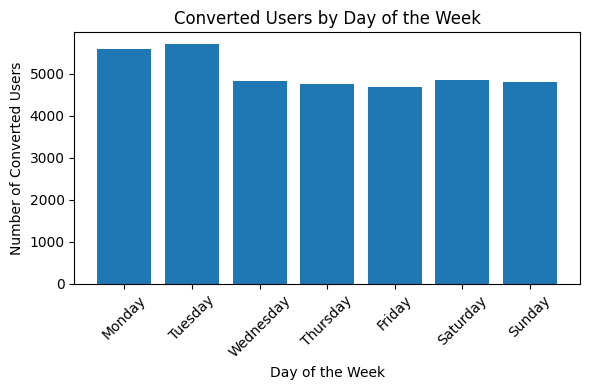

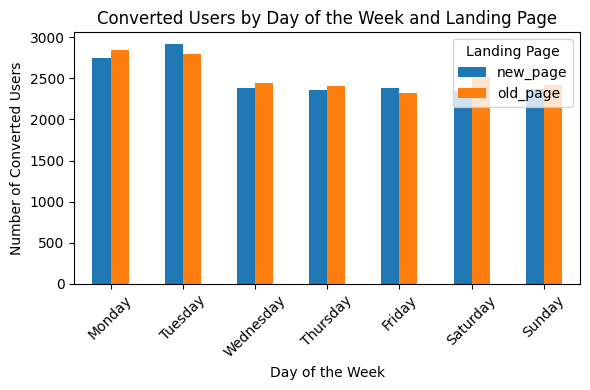

In [48]:
# Convert timestamp to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract day of the week
df['day_of_week'] = df['timestamp'].dt.day_name()

# Group by day of the week and count converted users
converted_by_day = df.groupby('day_of_week')['converted'].sum().reset_index()

# Order days of the week correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
converted_by_day['day_of_week'] = pd.Categorical(converted_by_day['day_of_week'], categories=days_order, ordered=True)
converted_by_day = converted_by_day.sort_values('day_of_week')

# Plotting the bar chart
plt.figure(figsize=(6, 4))
plt.bar(converted_by_day['day_of_week'], converted_by_day['converted'])
plt.title('Converted Users by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Converted Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Group by day of the week and landing page, then count converted users
converted_by_day_and_page = df.groupby(['day_of_week', 'landing_page'])['converted'].sum().unstack().fillna(0)

# Order days of the week correctly
converted_by_day_and_page = converted_by_day_and_page.reindex(days_order)


# Plotting the bar chart
converted_by_day_and_page.plot(kind='bar', figsize=(6, 4))
plt.title('Converted Users by Day of the Week and Landing Page')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Converted Users')
plt.xticks(rotation=45)
plt.legend(title='Landing Page')
plt.tight_layout()
plt.show()


We can notice that conversion rates are high on monday and tuesday; and at certain time of the day.

Limiting these instances of time and day may alter the results of A/B Testing.